Name- Jaival Bhavsar

Stream - AIML

Exam - Deep Learning Unit 2

Dataset - Car Damaged Part Detection

In [22]:
import torch, torchvision

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import cv2

import os
import json
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image
from scipy.spatial import distance

%matplotlib inline
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataDir='/content/drive/MyDrive/New folder (2)/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "/content/drive/MyDrive/New folder (2)/img"
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [23]:
plt.rcParams["figure.figsize"] = [16,9]

In [8]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vtemhwpx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vtemhwpx
  Resolved https://github.com/facebookresearch/detectron2.git to commit a2e43eab54d28ffbd59f5e9b4e3193b82faeb70f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6111763 sha256=137e97456882ef3b7735d48be4af1215

In [7]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

plt.rcParams["figure.figsize"] = [16,9]

In [8]:
!python -m detectron2.utils.collect_env

-------------------------------  -----------------------------------------------------------------
sys.platform                     linux
Python                           3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
numpy                            1.22.4
detectron2                       0.6 @/usr/local/lib/python3.10/dist-packages/detectron2
Compiler                         GCC 11.3
CUDA compiler                    CUDA 11.8
detectron2 arch flags            7.5
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.0.1+cu118 @/usr/local/lib/python3.10/dist-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            Tesla T4 (arch=7.5)
Driver version                   525.105.17
CUDA_HOME                        /usr/local/cuda
Pillow                           8.4.0
torchvision                      0.15.2+cu118 @/usr/local/lib/python3.10/dist-packages/torchv

In [9]:
dataset_dir = "/content/drive/MyDrive/New folder (2)"
img_dir = "/content/drive/MyDrive/New folder (2)/img/"
train_dir = "/content/drive/MyDrive/New folder (2)/train/"
val_dir = "/content/drive/MyDrive/New folder (2)/val/"

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_mul_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 2 # only has one class (damage) + 1
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/damage_segmentation_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg['MODEL']['DEVICE']='cuda'#or cpu
damage_predictor = DefaultPredictor(cfg)

[07/24 16:50:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/damage_segmentation_model.pth ...


  pixel_mean
  pixel_std


In [13]:
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 6  # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 6 # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/part_segmentation_model.pth")
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg_mul['MODEL']['DEVICE']='cuda' #or cpu
part_predictor = DefaultPredictor(cfg_mul)

[07/24 16:50:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/part_segmentation_model.pth ...


  pixel_mean
  pixel_std


In [14]:
def detect_damage_part(damage_dict, parts_dict):
  """
  Returns the most plausible damaged part for the list of damages by checking the distance
  between centers centers of damage_polygons and parts_polygons

  Parameters
  -------------
   damage_dict: dict
                Dictionary that maps damages to damage polygon centers.
   parts_dict: dict
                Dictionary that maps part labels to parts polygon centers.
  Return
  ----------
  part_name: str
            The most plausible damaged part name.
  """
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    for y in parts_dict.keys():
        for x in damage_dict.keys():
          dis = distance.euclidean(damage_dict[x], parts_dict[y])
          if dis < max_distance_dict[x]:
            part_name[x] = y.rsplit('_',1)[0]

    return list(set(part_name.values()))
  except Exception as e:
    print(e)

In [15]:
damage_class_map= {0:'damage'}
parts_class_map={0:'headlamp',1:'rear_bumper', 2:'door', 3:'hood', 4: 'front_bumper'}

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


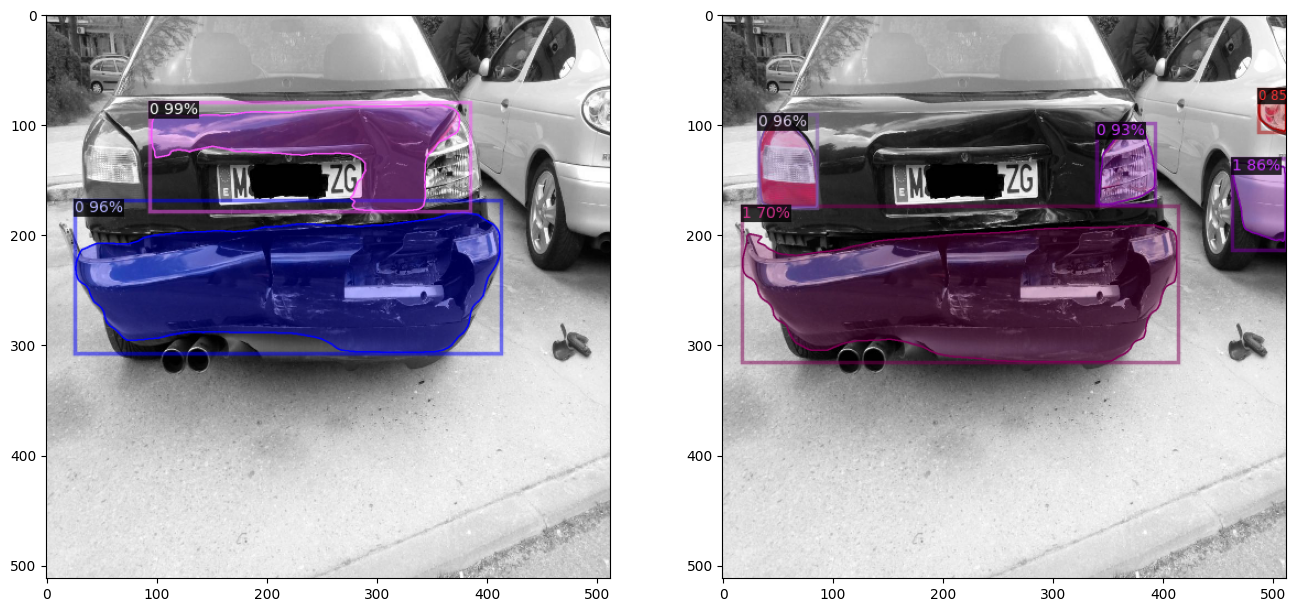

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("/content/drive/MyDrive/New folder (2)/val/32.jpg")

#damage inference
damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_dataset_val"),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

#part inference
parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_mul_dataset_val"),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

#plot
ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

In [18]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

In [19]:
parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()

#Remove centers which lie in beyond 800 units
parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

In [20]:
print("Damaged Parts: ",detect_damage_part(damage_dict,parts_dict))

Damaged Parts:  ['rear_bumper']
